# Assignment 4 - Generative Adversarial Networks
 
**Authors:**

1.   Liav Bachar 205888472
2.   Naor Kolet 205533060


# Imports

In [42]:
import pandas as pd
import numpy as np



# TensorFlow
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Multiply, Concatenate, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, KLDivergence


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score #confusion_matrix, 
# from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import log_loss
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
 
# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
from scipy.io import arff
import os
import random
import joblib
import cv2
from glob import glob
from tqdm import tqdm_notebook as tqdm
import time

%matplotlib inline

In [2]:
SEED = 42
def set_seed():    
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

set_seed()

NOISE_DIM=1024

# Load Data

In [3]:
def load_arff_dataset(arff_path):
    data = arff.loadarff(arff_path)
    df = pd.DataFrame(data=data[0], columns=data[1].names())
    
    return df

In [4]:
# https://www.kaggle.com/uciml/pima-indians-diabetes-database
diab_df = load_arff_dataset(r'datasets/diabetes.arff')

In [5]:
diab_df

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [5]:
# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
cred_df = load_arff_dataset(r'datasets/german_credit.arff')

In [6]:
a = [(i+1, cred_df.iloc[:, i].unique()) for i in range (cred_df.shape[1])]
for i in range(len(a)):
    if i+1 not in [2, 5, 13]:
        print(a[i] )
# cred_df.loc[:,'1'].unique()

(1, array([b'A11', b'A12', b'A14', b'A13'], dtype=object))
(3, array([b'A34', b'A32', b'A33', b'A30', b'A31'], dtype=object))
(4, array([b'A43', b'A46', b'A42', b'A40', b'A41', b'A49', b'A44', b'A45',
       b'A410', b'A48'], dtype=object))
(6, array([b'A65', b'A61', b'A63', b'A64', b'A62'], dtype=object))
(7, array([b'A75', b'A73', b'A74', b'A71', b'A72'], dtype=object))
(8, array([4., 2., 3., 1.]))
(9, array([b'A93', b'A92', b'A91', b'A94'], dtype=object))
(10, array([b'A101', b'A103', b'A102'], dtype=object))
(11, array([4., 2., 3., 1.]))
(12, array([b'A121', b'A122', b'A124', b'A123'], dtype=object))
(14, array([b'A143', b'A141', b'A142'], dtype=object))
(15, array([b'A152', b'A153', b'A151'], dtype=object))
(16, array([2., 1., 3., 4.]))
(17, array([b'A173', b'A172', b'A174', b'A171'], dtype=object))
(18, array([1., 2.]))
(19, array([b'A192', b'A191'], dtype=object))
(20, array([b'A201', b'A202'], dtype=object))
(21, array([b'1', b'2'], dtype=object))


# Preprocess Data

@attribute preg real
@attribute plas real
@attribute pres real
@attribute skin real
@attribute insu real
@attribute mass real
@attribute pedi real
@attribute age real
@attribute class {tested_negative,tested_positive}

In [44]:

diab_ct = make_column_transformer(
    (MinMaxScaler(), ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']),
    (OrdinalEncoder(), ['class']),
    n_jobs=-1
)

In [54]:
diab_ct.transformers_

[('minmaxscaler',
  MinMaxScaler(),
  ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']),
 ('ordinalencoder', OrdinalEncoder(), ['class'])]

In [50]:
diab_data = diab_ct.fit_transform(diab_df)
diab_x, diab_y = diab_data[:, :-1], diab_data[:, -1]
diab_x.shape, diab_y.shape

((768, 8), (768,))

@attribute 1 {A11, A12, A13, A14}
@attribute 2 numeric 
@attribute 3 {A30, A31, A32, A33, A34}
@attribute 4 {A40, A41, A42, A43, A44, A45, A46, A47, A48, A49, A410}
@attribute 5 numeric
@attribute 6 {A61, A62, A63, A64, A65}
@attribute 7 {A71, A72, A73, A74, A75}
@attribute 8 numeric
@attribute 9 {A91, A92, A93, A94, A95}
@attribute 10 {A101, A102, A103}
@attribute 11 numeric
@attribute 12 {A121, A122, A123, A124}
@attribute 13 numeric
@attribute 14 {A141, A142, A143}
@attribute 15 {A151, A152, A153}
@attribute 16 numeric
@attribute 17 {A171, A172, A173, A174}
@attribute 18 numeric
@attribute 19 {A191, A192}
@attribute 20 {A201, A202}
@attribute 21 {1,2}

In [129]:

class ContinuousCategoryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        

    def fit(self, X, y=None):
        self.unique_v = [np.unique(X[:, i]) for i in range(X.shape[1])]
        self.unique_v_len = [len(self.unique_v[i]) for i in range(X.shape[1])]
        self.interval = [1 / self.unique_v_len[i]   for i in range(X.shape[1])]
        return self

    def transform(self, X, y=None):
        
        X_ = X.copy()
        X_ = np.concatenate([np.expand_dims(X_[:, i] / self.unique_v_len[i], axis=1) for i in range(X_.shape[1])], axis=1)
        for i in range(X_.shape[1]):
            new_col =  [np.random.uniform(val, min(1, val + self.interval[i]), 1) for val in X_[:, i]]
            new_col = np.concatenate(new_col, axis=0)
            X_[:, i] = new_col.copy()
        
        return X_
    
    def inverse_transform(self, X):
        X_ = X.copy()
        
        for i in range(X.shape[1]):
            rng = np.arange(0, 1, self.interval[i])
             
            def floor_array(val):
                idx = np.argmin(val>=rng)
                if idx == 0:
                    idx = len(rng) - 1
                else:
                    idx = idx - 1
                
                return self.unique_v[i][idx]
            
            def array_map(x):
                return np.array(list(map(floor_array, x)))

            X_[:,i] = array_map(X[:,i]) 
        
        return X_
            
        
        
    

In [130]:
categorical_pipe = Pipeline(steps=[('cat', OrdinalEncoder()), ('cont_trans' ,ContinuousCategoryTransformer())])

cred_ct = make_column_transformer(
    (MinMaxScaler(), ['2', '5', '13']),
    (categorical_pipe, ['8', '11',  '16', '18', '1', '3', '4', '6', '7', '9', '10', '12', '14', '15', '17', '19', '20']),
    (OrdinalEncoder(), ['21']),
    n_jobs=-1
)

In [131]:

cred_data = cred_ct.fit_transform(cred_df)

cred_x, cred_y = cred_data[:, :-1], cred_data[:, -1]
cred_x.shape, cred_y.shape

((1000, 20), (1000,))

# Model Architecture

In [14]:
def generator_model(noise_shape, output_shape):
    inp = Input(shape=noise_shape)

    X = Dense(512, activation=LeakyReLU(alpha=0.2))(inp)
    X = BatchNormalization()(X)
    X = Dense(256, activation=LeakyReLU(alpha=0.2))(X)
    X = BatchNormalization()(X)
    X = Dense(128, activation=LeakyReLU(alpha=0.2))(X)
    X = BatchNormalization()(X)
    X = Dense(64, activation=LeakyReLU(alpha=0.2))(X)
    X = BatchNormalization()(X)
    X = Dense(32, activation=LeakyReLU(alpha=0.2))(X)
    X = BatchNormalization()(X)
    X = Dense(16, activation=LeakyReLU(alpha=0.2))(X)
    
    out = Dense(output_shape, activation='sigmoid')(X)
    
    model = Model(inp, out)
    
    return model

In [15]:
def discriminator_model(input_shape, dataset_type):
    inp = Input(shape=input_shape)
    X = Dense(64, activation='relu')(inp)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X) 
    X = Dropout(0.5)(X)
    X = Dense(16, activation='relu')(X)
    X = Dropout(0.5)(X)

    out = Dense(1, activation='sigmoid')(X)
        
    
    model = Model(inp, out)
    
    return model

In [16]:
bce = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    real_loss = bce(tf.ones_like(real), real)
    fake_loss = bce(tf.zeros_like(fake), fake)
    total_loss = (real_loss + fake_loss) / 2
    return total_loss

def generator_loss(fake):
    return bce(tf.ones_like(fake), fake)

def discriminator_acc(real, fake):
    real_acc = accuracy_score(tf.ones_like(real), np.around(real))
    fake_acc = accuracy_score(tf.zeros_like(fake), np.around(fake))
    
    return real_acc, fake_acc
    


In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(samples, generator_model, discriminator_model, batch_size, noise_dim):
    generator, genr_opt = generator_model
    discriminator, disc_opt = discriminator_model
    
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_samples = generator(noise, training=True)

        real_output = discriminator(samples, training=True)
        fake_output = discriminator(generated_samples, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        disc_real_acc, disc_fake_acc = discriminator_acc(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    genr_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, disc_real_acc, disc_fake_acc

In [18]:
def train_gan(train_data, epochs=50, noise_dim=5, batch_size=64, buffer_size=10000, dataset_type='diab'):
    set_seed()
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(buffer_size).batch(batch_size)
    gen_loss_lst, disc_loss_lst, real_acc_lst, fake_acc_lst = [], [], [], []
    
    discriminator = discriminator_model(train_data.shape[1], dataset_type)
    generator = generator_model(noise_dim, train_data.shape[1])
    
    disc_model = (discriminator, Adam(1e-4))
    genr_model = (generator, Adam(1e-4))

    for epoch in tqdm(range(epochs)):
        start = time.time()
        gen_loss, disc_loss, real_acc, fake_acc = 0, 0, 0, 0
        num_batchs = 0
        
        for sample_batch in train_dataset:
            num_batchs += 1
            curr_gen_loss, curr_disc_loss, curr_real_acc, curr_fake_acc = train_step(sample_batch, genr_model, disc_model, batch_size=batch_size, noise_dim=noise_dim)
            gen_loss += curr_gen_loss
            disc_loss += curr_disc_loss
            real_acc += curr_real_acc
            fake_acc += curr_fake_acc
            
        gen_loss_epoch, disc_loss_epoch = gen_loss/num_batchs, disc_loss/num_batchs
        real_acc_epoch, fake_acc_epoch = real_acc/num_batchs, fake_acc/num_batchs
        gen_loss_lst.append(gen_loss_epoch)
        disc_loss_lst.append(disc_loss_epoch)
        real_acc_lst.append(real_acc_epoch)
        fake_acc_lst.append(fake_acc_epoch) 
        
        
    return generator, discriminator, gen_loss_lst, disc_loss_lst, real_acc_lst, fake_acc_lst

In [19]:
def visualize_perf(disc_lst, gen_lst, real_acc, fake_acc, width=10, height=6):
    df_loss = pd.DataFrame(data={'Discriminator Loss': disc_lst,
                                 'Generator Loss': gen_lst,
                                 'Discriminator Real Accuracy': real_acc,
                                 'Discriminator Fake Accuracy': fake_acc}) 
    
    plt.figure(figsize=(width, height))
    handle = plt.plot(df_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss/accuracy')
    plt.legend(handle, df_loss.columns)
    plt.show()
    
    

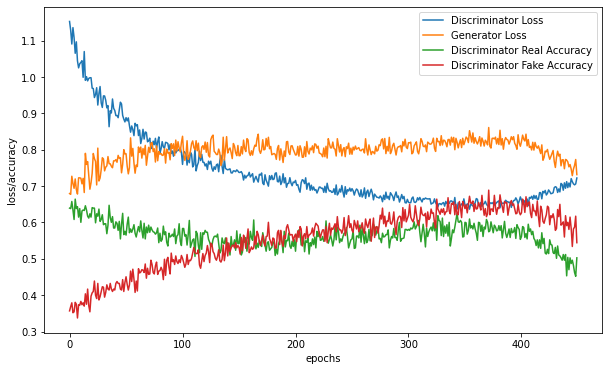

In [20]:
generator_diab, discriminator_diab, gen_loss_diab, disc_loss_diab, real_acc_diab, fake_acc_diab = train_gan(diab_x, epochs=450, dataset_type='diab',  noise_dim=NOISE_DIM)
visualize_perf(disc_loss_diab, gen_loss_diab, real_acc_diab, fake_acc_diab)

As we can see here the models are going back and forth with their losses, but the discriminator is a consistent leader.

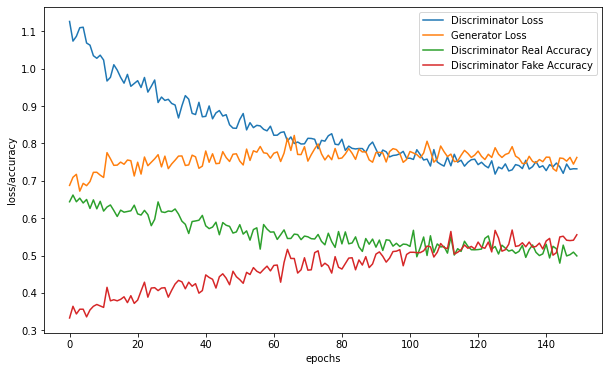

In [21]:
generator_cred, discriminator_cred, gen_loss_cred, disc_loss_cred , real_acc_cred, fake_acc_cred = train_gan(cred_x, epochs=150, dataset_type='cred', noise_dim=NOISE_DIM)
visualize_perf(disc_loss_cred, gen_loss_cred, real_acc_cred, fake_acc_cred)

In the previous Architecture the Discriminator beat the generator easily, thus we have added regularization to slow down the discriminator. in the graph above we see that the generator and discriminator are "fighting" to take the lead and there is no a consistent leader.

## save models

In [192]:
tf.keras.models.save_model(generator_diab, r'./models/diab/generator_diab.h5')
tf.keras.models.save_model(discriminator_diab, r'./models/diab/discriminator_diab.h5')
tf.keras.models.save_model(generator_cred, r'./models/cred/generator_cred.h5')
tf.keras.models.save_model(discriminator_cred, r'./models/cred/discriminator_cred.h5')

## Analyzing model

### Samples that are fooling The Discrimnator

In [28]:
def generate_samples(generator, discriminator, num_samples, noise_dim=NOISE_DIM):
    noise = tf.random.normal([num_samples, noise_dim])
    generated_samples = generator(noise, training=False)
    disc_pred = discriminator(generated_samples, training=False)
    
    return generated_samples, disc_pred


In [29]:
def get_samples(num_fools, generator, discriminator, noise_dim=NOISE_DIM, fool=True):
    generated_samples, disc_pred = generate_samples(generator, discriminator, num_fools * 5, noise_dim)
    disc_pred, generated_samples = disc_pred.numpy(), generated_samples.numpy()
    
    if fool:
        cond = disc_pred >= 0.495
        disc_pred_filtered = disc_pred[cond]
        samples_idx = np.argsort(disc_pred_filtered)[-num_fools:]
    else:
        cond = disc_pred < 0.505
        disc_pred_filtered = disc_pred[cond]
        samples_idx = np.argsort(disc_pred_filtered)[:num_fools]
    
    return disc_pred_filtered[samples_idx], generated_samples[(cond).reshape(-1), :][samples_idx, :]
    

### PCA

In [364]:
def pca_visualization(real_data, fake_data, disc=None):
    pca = PCA(n_components=2)


    principalComponents_real = pca.fit_transform(real_data)
    principalComponents_fake = pca.transform(fake_data)
    
    principalDf_real = pd.DataFrame(data = principalComponents_real, columns = ['pc1', 'pc2'])
    principalDf_fake = pd.DataFrame(data = principalComponents_fake, columns = ['pc1', 'pc2'])
    if disc:
        fake_preds = disc(fake_data,training=False).numpy()
        principalDf_fake['preds'] = fake_preds
        
    fig, ax = plt.subplots(figsize=(10, 10))
    handles =  [None, None]
    handles[0] = ax.plot(principalDf_real['pc1'],principalDf_real['pc2'],  '.', alpha=0.3, markersize=12)[0]
    if disc:
        sns.scatterplot(data=principalDf_fake, x='pc1', y='pc2',hue='preds',  alpha=1, palette='plasma', ax=ax)
    else:
        handles[1] = ax.plot(principalDf_fake['pc1'],principalDf_fake['pc2'],  '.', alpha=0.7, markersize=12)[0]
    
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    if not disc:
        plt.legend(handles, ['real', 'fake'])
    plt.show()
    

**Diabities Dataset**

In [27]:
fooled_diab = get_samples(300, generator_diab, discriminator_diab, noise_dim=NOISE_DIM, fool=True)

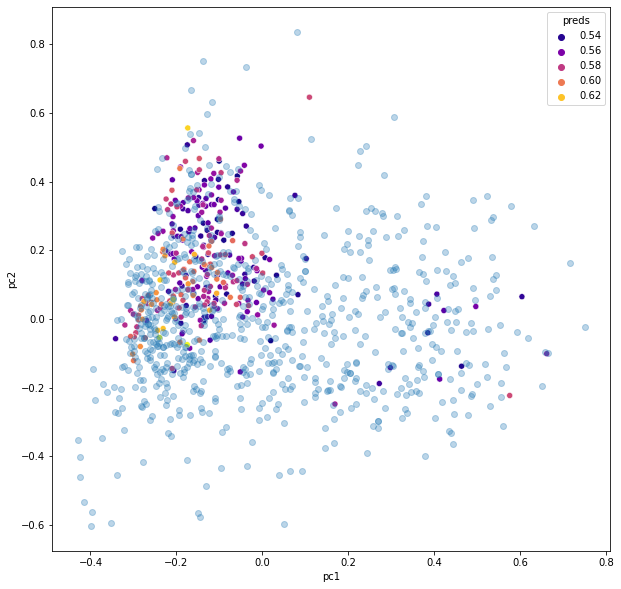

In [355]:
pca_visualization(diab_x, fooled_diab[1], discriminator_diab)

As we can see the 'fake' samples are varied but the most of them distribute across the center mass of the real data

**German Credit Dataset**

In [356]:
fooled_cred = get_samples(500, generator_cred, discriminator_cred, noise_dim=NOISE_DIM, fool=True)

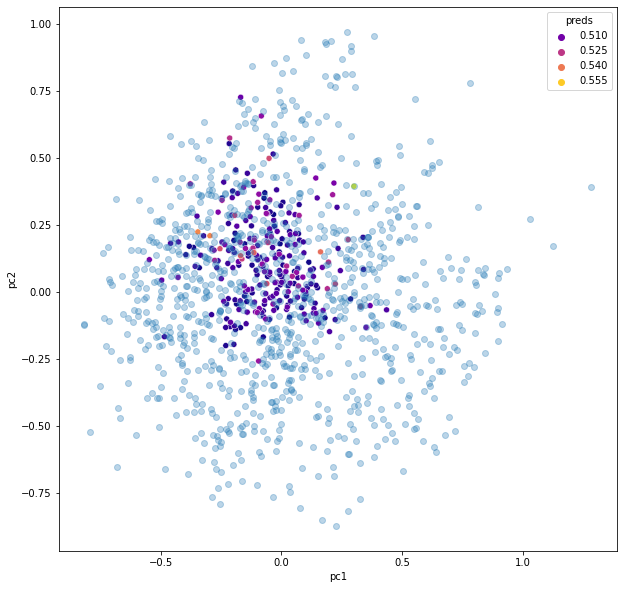

In [358]:
pca_visualization(cred_x, fooled_cred[1], discriminator_cred)

As we can see the 'fake' samples are centerlaized

### Samples that fooled and failed to fool the Discriminator

**Diabities Dataset**

In [147]:
fooled_diab = get_samples(10, generator_diab, discriminator_diab, noise_dim=NOISE_DIM, fool=True)

In [148]:
not_fooled_diab = get_samples(10, generator_diab, discriminator_diab, noise_dim=NOISE_DIM, fool=False)

In [144]:
def inverse_to_df_diab(ct, data):
    a = ct.transformers_[0][1].inverse_transform(data[1])
    return pd.DataFrame(a, columns=['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age'])


In [145]:
inverse_to_df_diab(diab_ct,fooled_diab)

,preg,plas,pres,skin,insu,mass,pedi,age
0,0.158663,34.708313,84.037468,31.727705,24.356609,47.518661,0.251351,21.093899
1,1.241650,112.519722,83.125618,52.721504,138.670303,40.918373,0.701302,25.488308
2,3.625142,111.262947,66.234428,9.254420,25.065178,25.780775,0.222628,22.519175
3,3.773528,146.987320,69.035477,44.030521,197.098389,39.677372,0.898537,25.204870
4,1.428326,164.665863,94.722542,35.031403,84.153831,37.308155,1.156131,22.341084
5,0.469938,93.434715,83.663239,25.231392,95.430527,44.504684,0.308338,21.903229
6,1.478666,126.497383,88.649124,7.528594,49.383339,39.586967,0.525324,22.592855
7,0.454601,84.617874,97.371895,27.948792,42.116722,35.823727,0.520066,21.703968
8,0.578249,67.059593,87.922134,24.099701,43.694199,53.093410,0.195547,22.025465
9,0.824118,113.325905,97.510811,5.577373,34.788883,51.798180,0.533608,21.778587


In [146]:
inverse_to_df_diab(diab_ct, not_fooled_diab)

,preg,plas,pres,skin,insu,mass,pedi,age
0,4.140101,195.340088,16.282028,22.989685,265.609283,20.151493,0.475118,23.991137
1,2.657772,144.798447,103.089989,32.514133,166.388840,42.128956,0.892974,38.928532
2,8.282804,185.522995,59.391926,16.648687,86.848289,29.015654,0.602545,29.587654
3,6.686085,193.102783,59.603878,6.137139,33.443970,11.965335,0.546111,22.595106
4,5.156928,161.070572,105.231346,29.549438,107.442322,47.708294,0.679987,40.654549
5,13.766693,198.171844,54.131016,22.105110,77.902809,45.366219,0.470270,26.480175
6,9.758708,184.273453,57.159603,16.560352,106.572189,37.220737,0.297330,33.454582
7,4.603155,168.494781,97.958374,44.248966,179.735809,47.829887,0.523207,52.790142
8,5.780174,131.952576,83.664459,25.000698,122.295486,32.228870,0.682481,26.336708
9,6.175198,170.552734,80.311989,30.515005,82.900879,32.701363,0.483451,28.812332


**German Credit Dataset**

In [149]:
fooled_cred = get_samples(10, generator_cred, discriminator_cred, noise_dim=NOISE_DIM, fool=True)

In [150]:
def inverse_to_df(ct, data):
    a1 = ct.transformers_[0][1].inverse_transform(data[1][:,:3])
    a2 = ct.transformers_[1][1].inverse_transform(data[1][:,3:])
    return pd.DataFrame({'1':a2[:,4],
                    '2':a1[:,0],
                    '3':a2[:,5],
                    '4':a2[:,6],
                    '5':a1[:,1],
                    '6':a2[:,7],
                    '7':a2[:,8],
                    '8':a2[:,0],
                    '9':a2[:,9],
                    '10':a2[:,10],
                    '11':a2[:,1],
                    '12':a2[:,11],
                    '13':a1[:,2],
                    '14':a2[:,12],
                    '15':a2[:,13],
                    '16':a2[:,2],
                    '17':a2[:,14],
                    '18':a2[:,3],
                    '19':a2[:,15],
                    '20':a2[:,16]})


In [151]:
inverse_to_df(cred_ct,fooled_cred)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,b'A12',61.023411,b'A30',b'A43',8877.579102,b'A61',b'A72',3,b'A91',b'A103',4,b'A123',54.795403,b'A142',b'A152',2,b'A172',1,b'A191',b'A201'
1,b'A12',32.051117,b'A32',b'A43',10665.403320,b'A62',b'A73',3,b'A93',b'A102',3,b'A122',48.696892,b'A142',b'A152',3,b'A172',1,b'A192',b'A202'
2,b'A12',56.071442,b'A31',b'A410',15645.998047,b'A61',b'A72',2,b'A93',b'A101',4,b'A123',45.757324,b'A143',b'A152',3,b'A173',1,b'A191',b'A201'
3,b'A12',37.875397,b'A31',b'A42',11964.208008,b'A62',b'A72',2,b'A93',b'A102',3,b'A122',50.919865,b'A142',b'A152',2,b'A172',1,b'A192',b'A202'
4,b'A12',55.055401,b'A31',b'A44',11822.167969,b'A62',b'A72',2,b'A93',b'A102',3,b'A123',61.445999,b'A142',b'A153',1,b'A172',2,b'A191',b'A201'
5,b'A13',45.417725,b'A33',b'A43',10628.010742,b'A63',b'A73',2,b'A92',b'A102',3,b'A122',57.475040,b'A142',b'A152',2,b'A173',2,b'A191',b'A201'
6,b'A12',56.666409,b'A31',b'A42',12649.358398,b'A61',b'A73',3,b'A92',b'A102',4,b'A123',63.805565,b'A142',b'A153',2,b'A172',1,b'A191',b'A201'


In [152]:
not_fooled_cred = get_samples(10, generator_cred, discriminator_cred, noise_dim=NOISE_DIM, fool=False)

In [153]:
inverse_to_df(cred_ct,not_fooled_cred)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,b'A13',50.804226,b'A32',b'A45',8559.833984,b'A63',b'A73',1,b'A92',b'A101',3,b'A123',57.652756,b'A142',b'A153',2,b'A174',1,b'A191',b'A202'
1,b'A14',49.269924,b'A32',b'A43',6243.529297,b'A63',b'A74',2,b'A93',b'A101',1,b'A123',58.273209,b'A143',b'A153',1,b'A173',1,b'A191',b'A202'
2,b'A13',45.014214,b'A32',b'A43',12539.400391,b'A62',b'A73',2,b'A93',b'A101',3,b'A123',61.345402,b'A143',b'A152',2,b'A173',1,b'A191',b'A202'
3,b'A14',59.508793,b'A32',b'A40',13120.594727,b'A61',b'A74',2,b'A93',b'A102',3,b'A121',50.182762,b'A143',b'A152',3,b'A173',1,b'A191',b'A201'
4,b'A12',45.884754,b'A31',b'A49',10443.606445,b'A61',b'A72',1,b'A94',b'A103',1,b'A123',52.521374,b'A141',b'A152',1,b'A173',2,b'A191',b'A202'
5,b'A12',55.039448,b'A30',b'A42',11860.769531,b'A61',b'A72',3,b'A94',b'A102',4,b'A122',39.170494,b'A143',b'A152',3,b'A172',1,b'A191',b'A201'
6,b'A13',52.599129,b'A32',b'A42',9877.416992,b'A63',b'A74',2,b'A92',b'A102',2,b'A122',59.812569,b'A143',b'A152',1,b'A173',1,b'A192',b'A202'
7,b'A13',22.170221,b'A32',b'A43',11768.035156,b'A62',b'A73',2,b'A94',b'A101',3,b'A122',50.128960,b'A142',b'A152',2,b'A173',1,b'A191',b'A202'
8,b'A13',55.544941,b'A33',b'A410',12905.613281,b'A62',b'A73',2,b'A92',b'A103',3,b'A121',48.432262,b'A143',b'A152',2,b'A173',1,b'A192',b'A201'
9,b'A12',34.678627,b'A31',b'A44',10256.040039,b'A62',b'A73',3,b'A93',b'A102',3,b'A123',50.442585,b'A142',b'A152',2,b'A172',1,b'A192',b'A202'


### 100 Random Samples

Diab Random Samples

In [258]:
def pie_fool(predictions, unknown_threshold):
    num_fooled =  len(predictions[predictions > 0.5 + unknown_threshold])
    unknown = len(predictions[(predictions >= 0.5 - unknown_threshold) & (predictions <= 0.5 + unknown_threshold)])
    num_not_fooled = len(predictions) - num_fooled - unknown
    
    plt.pie([num_fooled,unknown, num_not_fooled], labels = ['Fool', 'Unknown', 'Not Fool'], autopct='%1.f%%',
        shadow=True, startangle=90, explode=(0.1,0.1,0.1))
    plt.show()
    

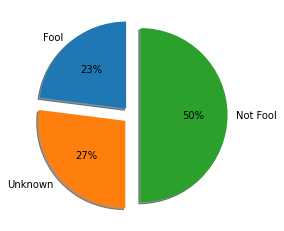

In [259]:
_, disc_pred_diab = generate_samples(generator_diab, discriminator_diab, 100, noise_dim=NOISE_DIM)
pie_fool(disc_pred_diab, 0.03)

Cred Random Samples

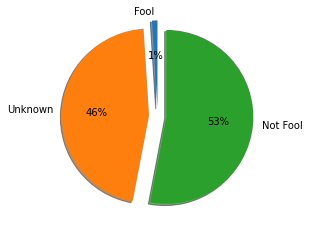

In [276]:
_, disc_pred_cred = generate_samples(generator_cred, discriminator_cred, 100, noise_dim=NOISE_DIM)
pie_fool(disc_pred_cred, 0.03)

# Part 2 - GAN with a twist

## Train Random Forest

In [204]:
diab_x_train, diab_x_test, diab_y_train, diab_y_test = train_test_split(diab_x, diab_y, test_size=0.3, random_state=SEED)
cred_x_train, cred_x_test, cred_y_train, cred_y_test = train_test_split(cred_x, cred_y, test_size=0.3, random_state=SEED)

In [205]:
diab_rfr = RandomForestClassifier(n_jobs=-1)
_ = diab_rfr.fit(diab_x_train, diab_y_train)

In [206]:
cred_rfr = RandomForestClassifier(n_jobs=-1)
_ = cred_rfr.fit(cred_x_train, cred_y_train)

In [207]:
def rfr_visulize_performance(rfr, test_x, test_y=None):
    if test_y is not None:
        print(f'Accuracy: {rfr.score(test_x, test_y)*100:.2f}%')
    confid_vals = rfr.predict_proba(test_x)[:,1]
    print(f'Maximum Confidence: {np.max(confid_vals):.2f}')
    print(f'Minimum Confidence: {np.min(confid_vals):.2f}')
    print(f'Average Confidence: {np.mean(confid_vals):.2f}')
    print(f'Median Confidence: {np.median(confid_vals):.2f}')
    _ = plt.hist(confid_vals)
    _ = plt.xlabel('Confidence Score')
    _ = plt.ylabel('Amount')

Accuracy: 75.76%
Maximum Confidence: 0.95
Minimum Confidence: 0.00
Average Confidence: 0.37
Median Confidence: 0.31


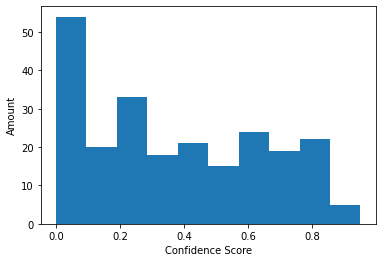

In [208]:
rfr_visulize_performance(diab_rfr, diab_x_test, diab_y_test)

Accuracy: 73.33%
Maximum Confidence: 0.80
Minimum Confidence: 0.00
Average Confidence: 0.31
Median Confidence: 0.27


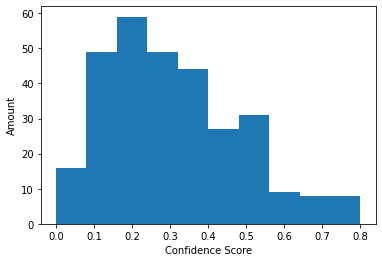

In [209]:
rfr_visulize_performance(cred_rfr, cred_x_test, cred_y_test)

## Twist GAN Architecture

In [277]:

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step_twist(generator_model, discriminator_model, rfr, batch_size, noise_dim):
    generator, genr_opt = generator_model
    discriminator, disc_opt = discriminator_model
    
    
    z = tf.random.normal([batch_size, noise_dim])
    c = tf.random.uniform([batch_size, 1], minval=0, maxval=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_samples = generator([z, c], training=True)
        
        y = rfr.predict_proba(generated_samples)[:,1]

        real_output = discriminator([generated_samples, y], training=True)
        fake_output = discriminator([generated_samples, c], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        disc_real_acc, disc_fake_acc = discriminator_acc(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    genr_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, disc_real_acc, disc_fake_acc 

In [282]:
def train_gan_twist(rfr, data_shape, epochs=50, steps=15, noise_dim=5, batch_size=64, dataset_type='diab'):
    set_seed()
    gen_loss_lst, disc_loss_lst, real_acc_lst, fake_acc_lst = [], [], [], []
    
    discriminator = discriminator_model_twist(data_shape, dataset_type)
    generator = generator_model_twist(noise_dim, data_shape)
    
    disc_model = (discriminator, Adam(1e-4))
    genr_model = (generator, Adam(1e-4))

    for epoch in tqdm(range(epochs)):
        start = time.time()
        gen_loss, disc_loss, real_acc, fake_acc = 0, 0, 0, 0
        num_batchs = 0
        
        for _ in range(steps):
            num_batchs += 1
            curr_gen_loss, curr_disc_loss, curr_real_acc, curr_fake_acc = train_step_twist(genr_model, disc_model, rfr, batch_size=batch_size, noise_dim=noise_dim)
            gen_loss += curr_gen_loss
            disc_loss += curr_disc_loss
            real_acc += curr_real_acc
            fake_acc += curr_fake_acc
            
        gen_loss_epoch, disc_loss_epoch = gen_loss/num_batchs, disc_loss/num_batchs
        real_acc_epoch, fake_acc_epoch = real_acc/num_batchs, fake_acc/num_batchs
        gen_loss_lst.append(gen_loss_epoch)
        disc_loss_lst.append(disc_loss_epoch)
        real_acc_lst.append(real_acc_epoch)
        fake_acc_lst.append(fake_acc_epoch) 
        
    return generator, discriminator, gen_loss_lst, disc_loss_lst, real_acc_lst, fake_acc_lst

In [283]:
def generator_model_twist(noise_shape, output_shape):
    input_noise = Input(shape=noise_shape)
    input_c = Input(shape=(1,))
    
    X = Concatenate()([input_noise, input_c])
    X = Dense(512, activation=LeakyReLU(alpha=0.2))(X)
    X = Concatenate()([X, input_c])
    X = BatchNormalization()(X)
    X = Dense(256, activation=LeakyReLU(alpha=0.2))(X)
    X = Concatenate()([X, input_c])
    X = BatchNormalization()(X)
    X = Dense(128, activation=LeakyReLU(alpha=0.2))(X)
    X = Concatenate()([X, input_c])
    X = BatchNormalization()(X)
    X = Dense(64, activation=LeakyReLU(alpha=0.2))(X)
    X = Concatenate()([X, input_c])
    X = BatchNormalization()(X)
    X = Dense(32, activation=LeakyReLU(alpha=0.2))(X)
    X = Concatenate()([X, input_c])
    X = BatchNormalization()(X)
    X = Dense(16, activation=LeakyReLU(alpha=0.2))(X)
    
    out = Dense(output_shape, activation='sigmoid')(X)
    
    model = Model([input_noise, input_c], out)
    
    return model

In [284]:
def discriminator_model_twist(input_shape, dataset_type):
    input_sample = Input(shape=input_shape)
    input_confid = Input(shape=(1,))
    
    X = Concatenate()([input_sample, input_confid])
    X = BatchNormalization()(X)
    X = Dense(32, activation=LeakyReLU(alpha=0.2))(X)
    X = Dense(16, activation=LeakyReLU(alpha=0.2))(X)
    X = Concatenate()([X, input_confid])
    
    out = Dense(1, activation='sigmoid')(X)
        
    
    model = Model([input_sample, input_confid], out)
    
    return model

In [285]:
gen_diab_tw, disc_diab_tw, gen_diab_loss_tw, disc_diab_loss_tw , real_acc_tw_diab, fake_acc_tw_diab = train_gan_twist(diab_rfr, diab_x.shape[1], epochs=300, noise_dim=NOISE_DIM)

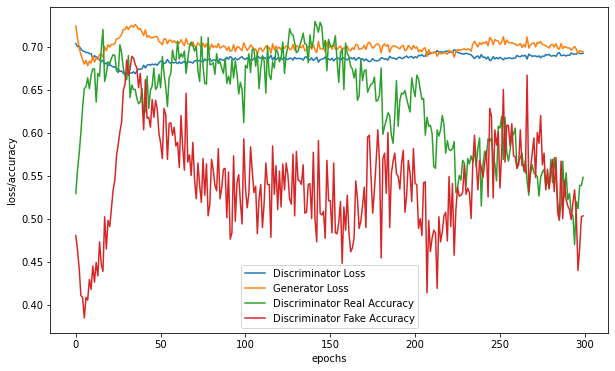

In [286]:
visualize_perf(disc_diab_loss_tw, gen_diab_loss_tw,  real_acc_tw_diab, fake_acc_tw_diab)

### Generating data

In [288]:
def generate_samples_twist(generator, discriminator, num_samples, noise_dim=5):
    noise = tf.random.normal([num_samples, noise_dim])
    confd = tf.random.uniform([num_samples, 1], minval=0, maxval=1)
    
    generated_samples = generator([noise, confd], training=False)
    disc_pred = discriminator([generated_samples, confd], training=False)
    
    return generated_samples, confd, disc_pred


In [289]:
diab_samples, diab_confd, diab_preds = generate_samples_twist(gen_diab_tw, disc_diab_tw, 1000, noise_dim=NOISE_DIM)

Maximum Confidence: 0.83
Minimum Confidence: 0.14
Average Confidence: 0.51
Median Confidence: 0.52


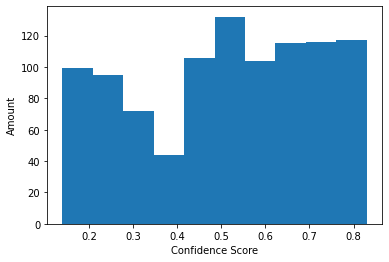

In [290]:
rfr_visulize_performance(diab_rfr, diab_samples)

In [291]:
y_diab = diab_rfr.predict_proba(diab_samples)[:,1]

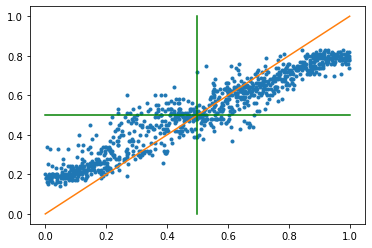

In [292]:
_ = plt.plot(diab_confd, y_diab, '.')
_ = plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
_ = plt.plot(np.arange(0,1.1,0.1), [0.5]*11, 'g-')
_ = plt.plot([0.5]*11, np.arange(0,1.1,0.1), 'g-')

In [293]:
print(f'Class prediction accuracy by confidence {accuracy_score(np.around(y_diab), np.around(diab_confd)) * 100:.2f}%')

Class prediction accuracy by confidence 88.30%


## PCA visualisation

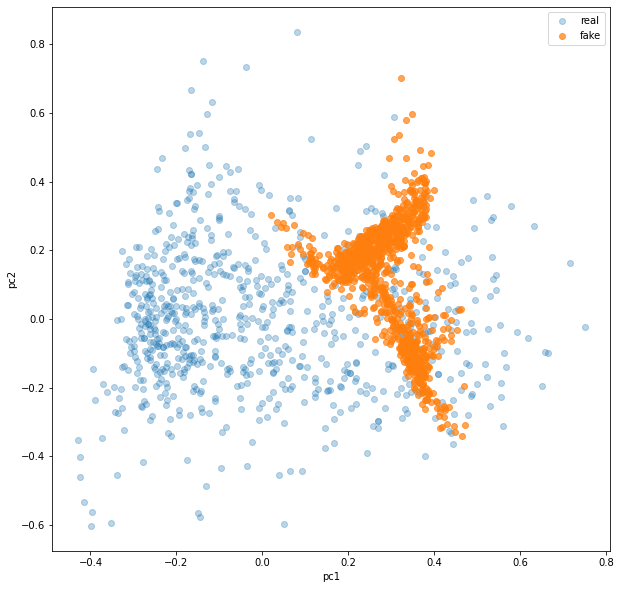

In [365]:
pca_visualization(diab_x, diab_samples)

## Cred

In [295]:
cred_gen_twx, cred_disc_twx, cred_genloss_twx, cred_discloss_twx,  real_acc_tw_cred, fake_acc_tw_cred = train_gan_twist(cred_rfr, cred_x.shape[1], epochs=250, noise_dim=NOISE_DIM)

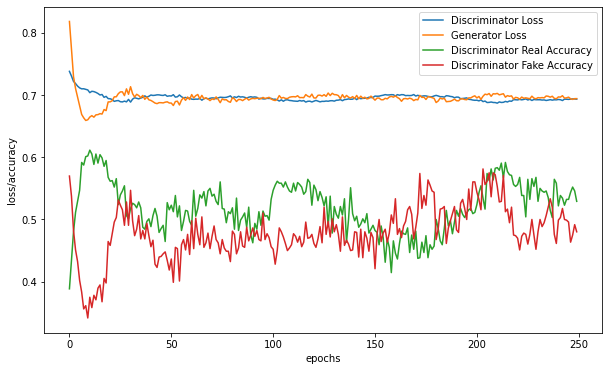

In [296]:
visualize_perf(cred_discloss_twx, cred_genloss_twx, real_acc_tw_cred, fake_acc_tw_cred)

In [297]:
cred_samples, cred_confd, cred_preds = generate_samples_twist(cred_gen_twx, cred_disc_twx, 1000, noise_dim=NOISE_DIM)

Maximum Confidence: 0.74
Minimum Confidence: 0.10
Average Confidence: 0.44
Median Confidence: 0.46


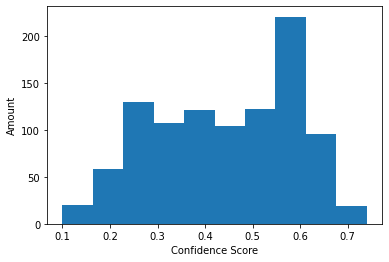

In [298]:
rfr_visulize_performance(cred_rfr, cred_samples)

In [299]:
y_cred = cred_rfr.predict_proba(cred_samples)[:,1]

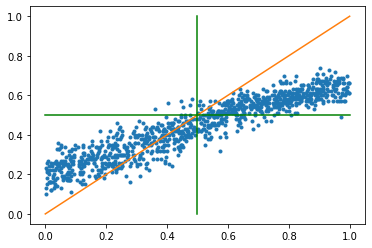

In [300]:
_ = plt.plot(cred_confd, y_cred, '.')
_ = plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
_ = plt.plot(np.arange(0,1.1,0.1), [0.5]*11, 'g-')
_ = plt.plot([0.5]*11, np.arange(0,1.1,0.1), 'g-')

In [301]:
print(f'Class prediction accuracy by confidence {accuracy_score(np.around(y_cred), np.around(cred_confd)) * 100:.2f}%')

Class prediction accuracy by confidence 90.50%


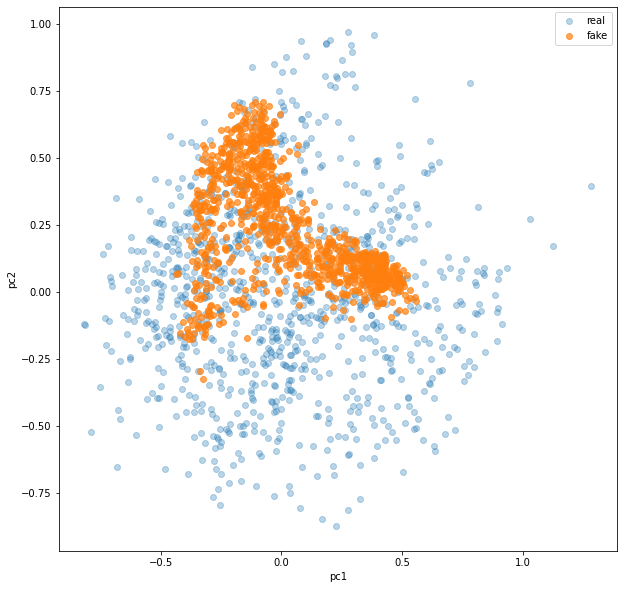

In [366]:
pca_visualization(cred_x, cred_samples)